# Expression of known genes
In this notebook, we'll take the gene sets that we identified in the transcriptomics_visualization notebook, and compare them to lists of known genes invovled in processed that we think may be important in driving the acclimatory phenotype at 2% oxygen.

In [96]:
from os import listdir
from os.path import splitext, abspath, isfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from make_DEG_figure import makeDEGfigure
from upsetplot import from_contents, plot, UpSet
import warnings
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the gene epxression data and the groups of genes:

In [97]:
exp_datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
time_comparisons = {}
o2_comparisons = {}
for f in listdir(exp_datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'vs':
        time_comparisons[name] = pd.read_csv(exp_datapath+f)
    elif f.split('_')[1] == 'o2':
        o2_comparisons[name] = pd.read_csv(exp_datapath+f)

In [98]:
filtered_time_comps = {
    '1h_vs_7h_2o2_filtered': pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/2_o2_7h_v_1h_filtered.csv'),
    '1h_vs_7h_40o2_filtered': pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/40_o2_7h_v_1h_filtered.csv')
}

In [99]:
lst_datapath = '../data/Araport11_outputs_ALL/gene_lists/'
gene_lists = {}
for f in listdir(lst_datapath):
    if f != 'reference_gene_list.txt' and isfile(lst_datapath+f):
        basename = splitext(f)[0][:-10]
        with open(lst_datapath+f) as f:
            gene_lists[basename] = [l.strip() for l in f.readlines()]

In [100]:
conditions_semantic = {
    '1h_vs_7h_2o2': '7 h vs. 1 h at 2% O$_{2}$',
    '1h_vs_7h_40o2': '7 h vs. 1 h at 40% O$_{2}$',
    '1h_vs_7h_21o2': '7 h vs. 1 h at 21% O$_{2}$',
    '1h_vs_7h_2o2_filtered': '7 h vs. 1 h at 2% O$_{2}$, filtered',
    '1h_vs_7h_40o2_filtered': '7 h vs. 1 h at 40% O$_{2}$, filtered',
    '1h_o2_2_21': '2% vs. 21% O$_{2}$ at 1 h',
    '1h_o2_40_21': '40% vs. 21% O$_{2}$ at 1 h',
    '7h_o2_2_21': '2% vs. 21% O$_{2}$ at 7 h',
    '7h_o2_40_21': '40% vs. 21% O$_{2}$ at 7 h',
    '40o2_all_comps_overlaps': '40% O$_{2}$, overlap between all comparisons',
    '2o2_all_comps_overlaps': '2% O$_{2}$, overlap between all comparisons'
}

## Presence of photosynthetic machinery

A standing hypothesis made by physiologists about apparatuses like photosynthesis is that we wouldn't necessarily expect to see changes at the omics level in response to an environmental stimulus, because the cost of not responding fast enough is high enough that the plant would have all the machinery onboard already. We can test this hypothesis by looking for the presence of photosynthetically-related machinery in our differentially expressed genes. We'll import gene ID's to seach for from a few sources:

* The GreenCut gene list
* A list of genes involved in carbohydrate metabolism
* Photorespiration genes

While there does not exist a comprehensive list of the genes involved in the light reactions, I was able to find a resource in the supplemental data of [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC9822700/#_ad93), of light reaction-related genes that are differentially expressed under certain conditions. Looking through the genes included, it appears as if the genes that code for subunits of the major players in photosynthesis are included.

### Read in photosynthetic gene lists:

In [101]:
with open('../data/photosynthesis_genes/carb_metabolism_genes.txt') as f:
    carb_met = [l.strip().lower() for l in f.readlines()]
carb_met[:5]

['at4g24620', 'at5g51820', 'at5g19220', 'at1g27680', 'at4g39210']

In [102]:
with open('../data/photosynthesis_genes/photorespiration_genes.txt') as f:
    photorespiration = [l.strip().lower() for l in f.readlines()]
photorespiration[:5]

['at5g36700', 'at3g14415', 'at3g14420', 'at2g13360', 'at1g23310']

A note on the photorespiration genes: In the [source table for these genes](https://www.annualreviews.org/content/table/10.1146/annurev.arplant.043008.091948.t1?fmt=ahah&fullscreen=true&lang=en), for some reason the 1's in the gene ID's are formatted as lowercase L's. We checked that replacing L with 1 resulted in a TAIR search result that matched the description in the table, and then manually changed this in our `.txt` file.

In [103]:
with open('../data/photosynthesis_genes/plastidCut2_genes.txt') as f:
    plastid_cut = [l.strip().lower() for l in f.readlines()]
plastid_cut[:5]

['at1g06690', 'at4g32770', 'at2g41040', 'at5g57030', 'at3g59890']

In [104]:
light_rxn_dfs = pd.read_excel('../data/photosynthesis_genes/PLD3-7-e475-s003.xlsx', sheet_name=None, header=2)
light_rxn_dfs.keys()

dict_keys(['ATP_synthase_DEG_DEseq2', 'Calvin Cycle', 'Cyclic_Electron_Flow_switch', 'Cytochrome_B6f_complex', 'LHCI proteins', 'LHCII proteins', 'NDA complex', 'Other_components_Electron_Flow', 'PSI Core proteins ', 'PSII core proteins', 'Regulatory Protein'])

In [105]:
light_rxn_dfs['ATP_synthase_DEG_DEseq2'].columns = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].iloc[1]
light_rxn_dfs['ATP_synthase_DEG_DEseq2'] = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].drop([0,1])
light_rxn_dfs['ATP_synthase_DEG_DEseq2']

1,gene,Sinusoidal Log2 Fold change,p.adjusted_S,Fluctuation Log2 Fold change,p.adjusted_F,AVG_TPM_C,AVG_TPM_S,AVG_TPM_F,Gene.name,Gene.Brief.Description
2,AT1G15700,-0.027932,0.87935,-0.35866,0.013251,4.76198,5.042359,4.069887,atpC2,"ATPase, F1 complex, gamma subunit protein"
3,AT4G32260,-0.148713,0.214356,-0.120932,0.325655,1631.566665,1577.776042,1618.384295,PDE334,"ATPase, F0 complex, subunit B/B', bacterial/ch..."
4,AT4G04640,-0.263944,0.000198,-0.080148,0.322218,1320.435898,1178.609476,1353.29015,atpC1,"ATPase, F1 complex, gamma subunit protein"
5,AT4G09650,-0.362608,0.001301,-0.214111,0.073365,1845.820232,1538.966136,1716.254467,atpD,F-type H -transporting ATPase subunit delta


In [106]:
all_light_rxns = [df['gene'].tolist() for df in light_rxn_dfs.values()]
all_light_rxns = [g.lower() for lst in all_light_rxns for g in lst]

In [107]:
lipids = pd.read_csv('../data/photosynthesis_genes/lipid_genes_holzl_and_dormann_2019.csv')
lipids.head()

,Gene,Enzymatic function,Protein,Localization,Mutanta,Mutant growth phenotypea,Reference(s)
0,At2g38040,?-Carboxyltransferase,"?-CT, CAC3",Stroma,NaN,NaN,132
1,AtCg00500 (plastome),?-Carboxyltransferase,"?-CT, accD",Stroma,NaN,NaN,126
2,At5g35360,Biotin carboxylase,"BC, CAC2",Stroma,NaN,NaN,134
3,At5g15530,Biotin carboxyl carrier protein,BCCP2,Stroma,cac1b,NaN,"26, 90"
4,At5g16390,Biotin carboxyl carrier protein,BCCP1,Stroma,cac1a,Embryolethal,"26, 90"


In [108]:
all_lipids = lipids.Gene.str.split(' ').str[0].str.lower().tolist()

In [109]:
ros_genes = pd.read_excel('../data/external_data/1-s2.0-S1360138504002043-applic1.xls', sheet_name=0, header=6)['AGI code c'].dropna().tolist()
ros_genes = [rg.split('.')[0].lower() for rg in ros_genes] # Drop the isoform decimal
print(f'There are {len(ros_genes)} ros genes. Snapshot: {ros_genes[:5]}')

There are 148 ros genes. Snapshot: ['at4g25100', 'at5g51100', 'at5g23310', 'at1g08830', 'at2g28190']


Define the semantic versions of all names to be used when making plots:

In [110]:
legend_semantic = {
    'plastidCut2': 'PlastidCut 2',
    'carb_met': 'Carbohydrate metabolism',
    'lipids': 'Lipid metabolism',
    'light_rxns': 'Light reactions',
    'photorespiration': 'Photorespiration',
    'ros_genes': 'ROS'
}

Check for overlaps between the groups:

In [111]:
genes_to_search = {
    'carb_met': list(set(carb_met)),
    'photorespiration': list(set(photorespiration)),
    'plastidCut2': list(set(plastid_cut)),
    'light_rxns': list(set(all_light_rxns)),
    'lipids': list(set(all_lipids)),
    'ros_genes': list(set(ros_genes))
}

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

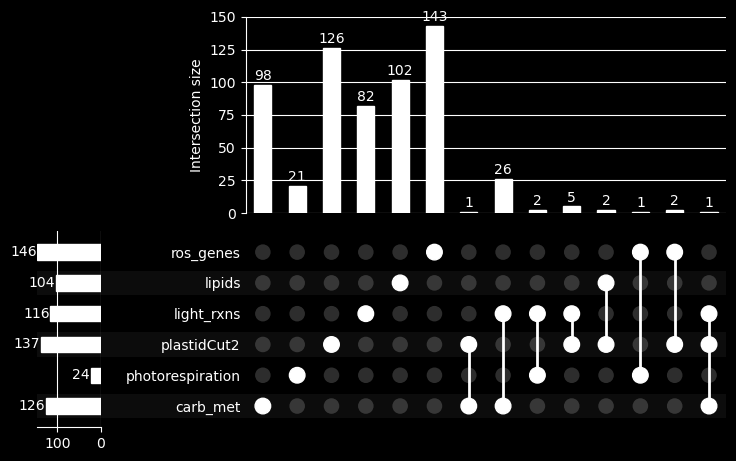

In [112]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

We want to assign genes to one of these groups uniquely; we'll do this by putting it in the most specific category. The order of specificity for these groups, from least to most:
* PlastidCut
* Carbohydrate Metabolism
* Lipids
* Light reactions
* ROS genes
* Photorespiration

In [113]:
specificity = ['plastidCut2', 'carb_met', 'lipids', 'light_rxns', 'ros_genes', 'photorespiration']
unique_genes_to_search = {}
for i, cat in enumerate(specificity[:-1]):
    current_cat = set(genes_to_search[cat])
    for subcat in specificity[i+1:]:
        prev_len = len(current_cat)
        current_cat -= set(genes_to_search[subcat])
        print(f'Removed {prev_len - len(current_cat)} genes from {cat} using {subcat}')
    unique_genes_to_search[cat] = list(current_cat)
unique_genes_to_search['photorespiration'] = genes_to_search['photorespiration'] 

Removed 2 genes from plastidCut2 using carb_met
Removed 2 genes from plastidCut2 using lipids
Removed 5 genes from plastidCut2 using light_rxns
Removed 2 genes from plastidCut2 using ros_genes
Removed 0 genes from plastidCut2 using photorespiration
Removed 0 genes from carb_met using lipids
Removed 27 genes from carb_met using light_rxns
Removed 0 genes from carb_met using ros_genes
Removed 0 genes from carb_met using photorespiration
Removed 0 genes from lipids using light_rxns
Removed 0 genes from lipids using ros_genes
Removed 0 genes from lipids using photorespiration
Removed 0 genes from light_rxns using ros_genes
Removed 2 genes from light_rxns using photorespiration
Removed 1 genes from ros_genes using photorespiration


Check that it worked:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

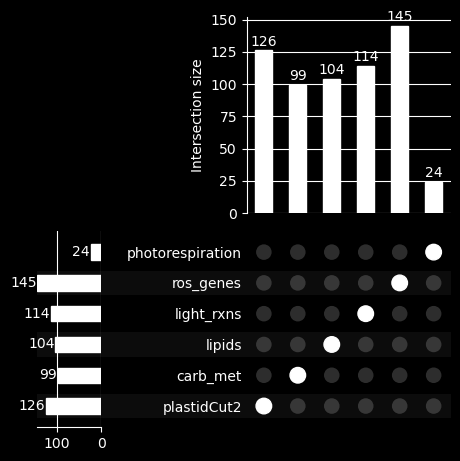

In [114]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(unique_genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

Save as a json for easier use in proteomics notebook:

In [115]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json', 'w') as f:
    json.dump(unique_genes_to_search, f)

### Analysis
Now check whether genes from these conditions are present in the comparisons. We'll once again do this separtely for the time and oxygen comparisons to keep the plots readable.

In [116]:
unique_genes_to_search = {legend_semantic[k]: v for k, v in unique_genes_to_search.items()}

In [117]:
unique_genes_to_search.keys()

dict_keys(['PlastidCut 2', 'Carbohydrate metabolism', 'Lipid metabolism', 'Light reactions', 'ROS', 'Photorespiration'])

In [118]:
genes_in_o2_comps = {}
for comp, df in o2_comparisons.items():
    genes_in_o2_comps[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

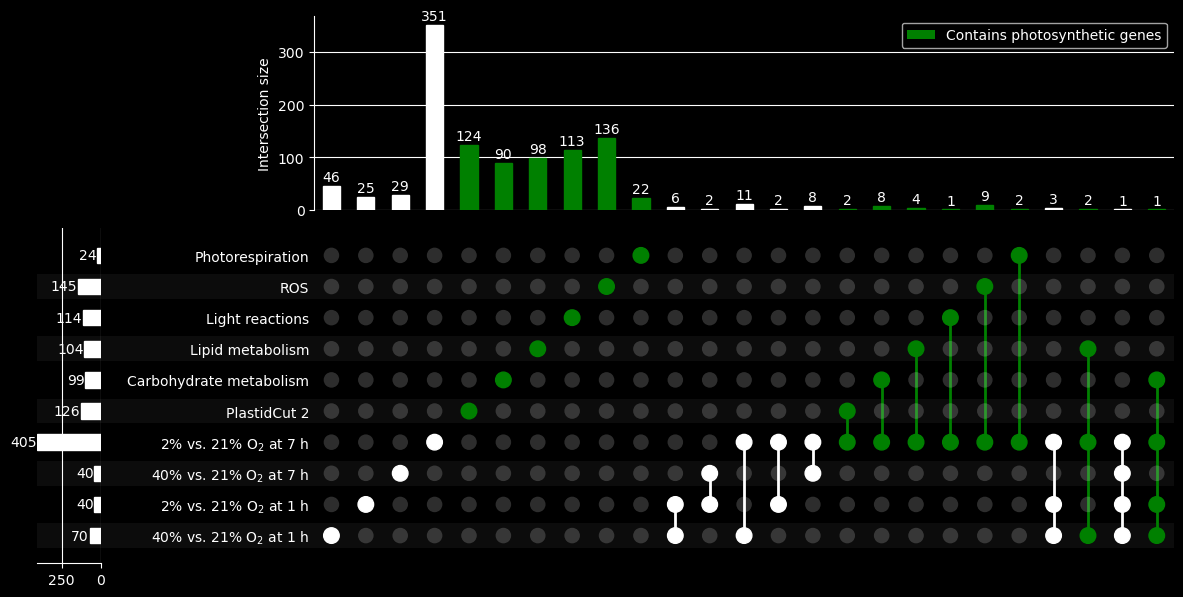

In [119]:
gene_groups_o2 = {k: [i.lower() for i in v] for k, v in genes_in_o2_comps.items()}
gene_groups_o2.update(unique_genes_to_search)
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups_o2)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
for c in unique_genes_to_search.keys():
    upset.style_subsets(present=c, facecolor="green", label="Contains photosynthetic genes")
upset.plot()
plt.savefig('../data/Araport11_outputs_ALL/figures/degs_o2_photosynthesis_UPSET.png', format='png', dpi=600, bbox_inches='tight')

In [120]:
genes_in_time_comps_filtered = {}
for comp, df in filtered_time_comps.items():
    genes_in_time_comps_filtered[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

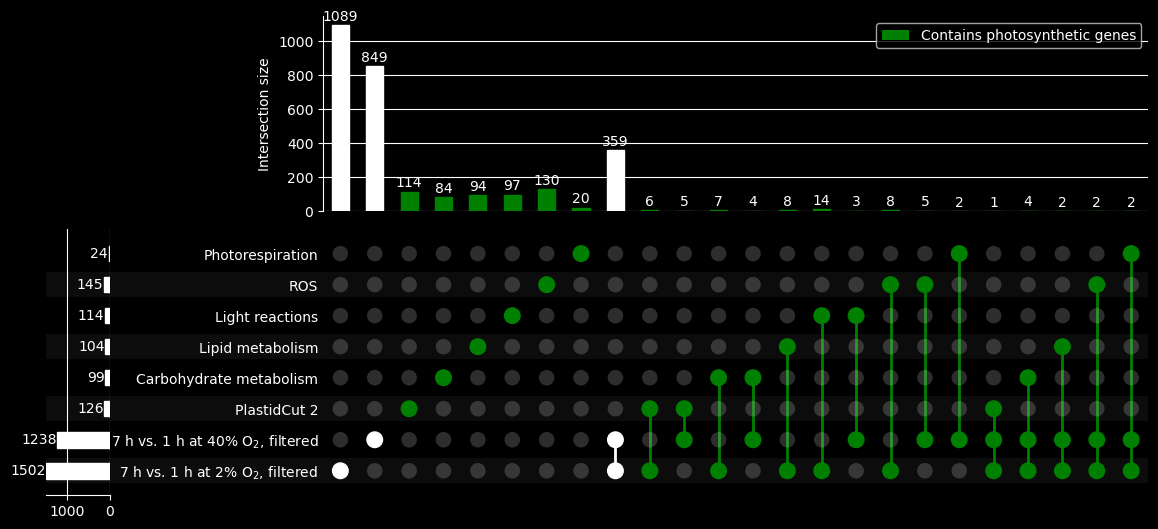

In [121]:
gene_groups_time = {k: [i.lower() for i in v] for k, v in genes_in_time_comps_filtered.items()}
gene_groups_time.update(unique_genes_to_search)
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups_time)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
for c in unique_genes_to_search.keys():
    upset.style_subsets(present=c, facecolor="green", label="Contains photosynthetic genes")
upset.plot()
plt.savefig('../data/Araport11_outputs_ALL/figures/degs_time_filtered_photosynthesis_UPSET.png', format='png', dpi=600, bbox_inches='tight')

There is a relatively minimal amount of overlap between the photosynthesis genes and those genes that are differentially expressed. For those genes that are present, what are the expression behaviors in the dataset?

We are interested in three pieces of information with this visualization:
* What DEG sets it’s in
* What the expression changes in each DEG set looks like
* Which photosynthesis gene group it came from

We're going to do this by stacking one subfigure per DEG set, put all genes that appear anywhere in the x-axis of all of them, and color the bars by the pathway in which they appear.

In [122]:
ara = pd.read_csv('../data/external_data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k.lower(): v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}

In [123]:
all_comparisons = dict(filtered_time_comps)
all_comparisons.update(o2_comparisons)

In [124]:
all_comparisons = {k: all_comparisons[k] for k in conditions_semantic.keys() if k in all_comparisons.keys()}

In [125]:
run_date = '22Apr2025'
# plt.style.use('dark_background')

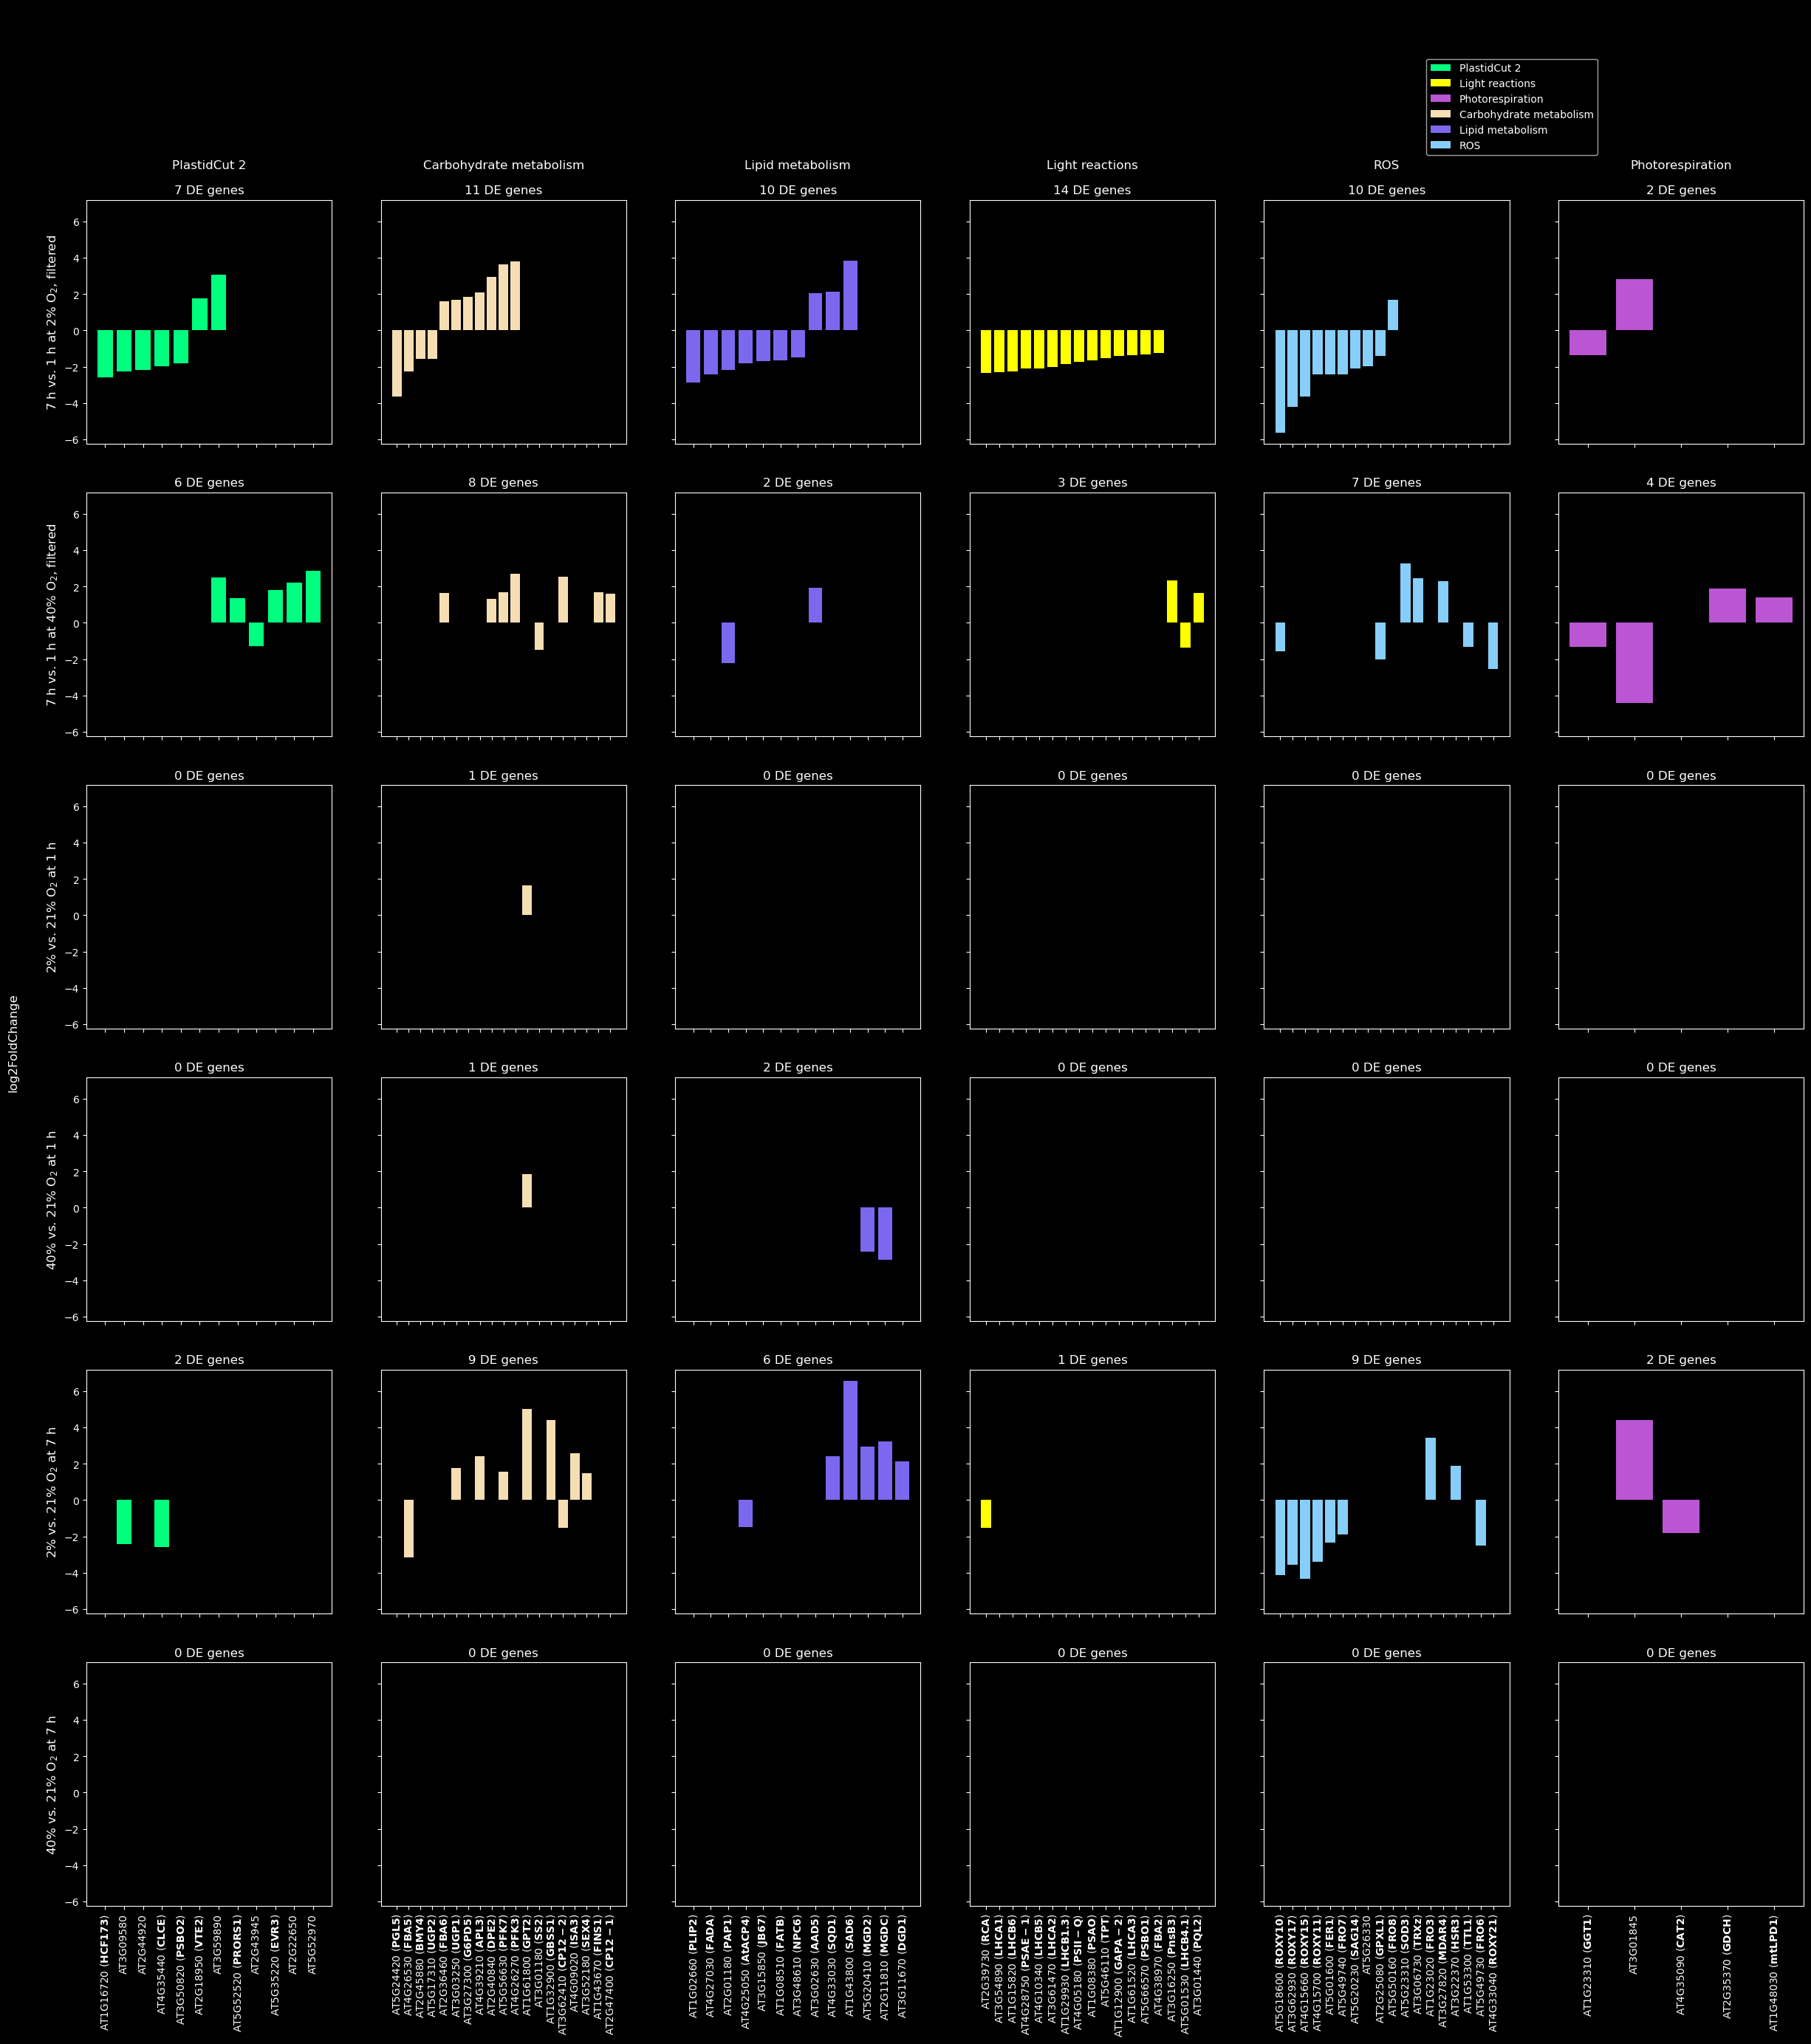

In [126]:
photosynth_colors = {'PlastidCut 2': 'springgreen', 'Carbohydrate metabolism': 'wheat', 'Lipid metabolism': 'mediumslateblue', 'Light reactions': 'yellow', 'Photorespiration': 'mediumorchid', 'ROS': 'lightskyblue'}
makeDEGfigure(all_comparisons, unique_genes_to_search, photosynth_colors, conditions_semantic, tair2gene, show_all_x=False, separate_columns=True)
plt.savefig(f'../data/Araport11_outputs_ALL/figures/degs_expression_photosynthesis_{run_date}.png', format='png', dpi=600, bbox_inches='tight')